C:\Users\pablo\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000639 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 717
[LightGBM] [Info] Number of data points in the train set: 410, number of used features: 17
[LightGBM] [Info] Start training from score 429345.141463
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

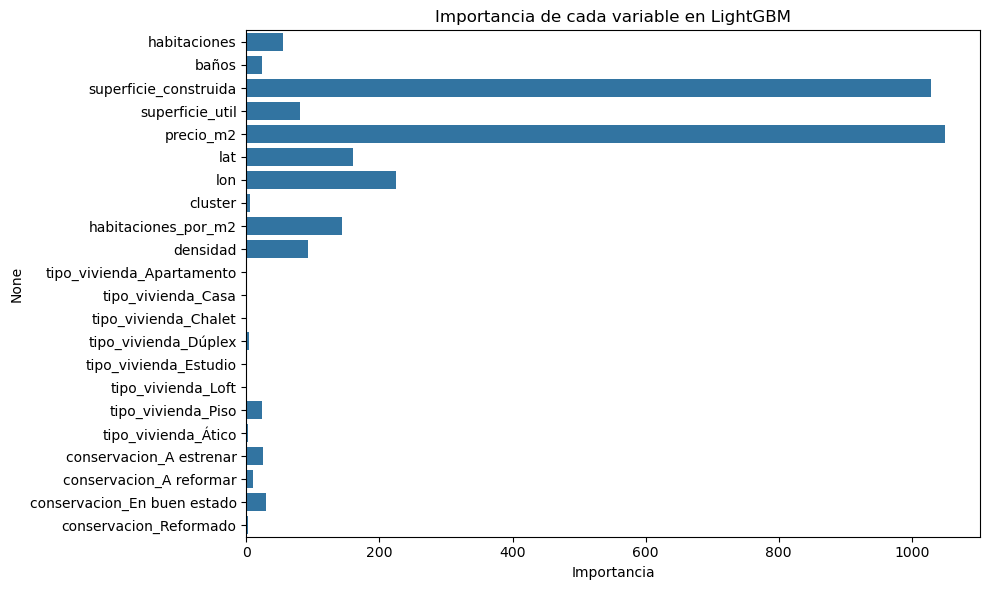


MAE por tipo de vivienda:
Piso: MAE = 11403.42 €
Dúplex: MAE = 27946.64 €
Apartamento: MAE = 14836.67 €
Ático: MAE = 16530.89 €


In [2]:
# Entrenamiento avanzado de modelo para ventas con LightGBM, explicabilidad y métricas extra
import os
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error
import joblib
from lightgbm import LGBMRegressor
import matplotlib.pyplot as plt
import seaborn as sns

# Evitar warning de MKL en Windows
os.environ["OMP_NUM_THREADS"] = "3"

# 1. Cargar datos
ruta = ("C:/Users/pablo/App_Pisos/data/ventas.csv")
df = pd.read_csv(ruta)

# 2. Filtrar y limpiar
df = df.dropna(subset=["precio", "habitaciones", "baños", "superficie_construida", "lat", "lon"])
df = df[(df["precio"] > 50000) & (df["precio"] < 5_000_000)]

# 3. Rellenar columnas útiles
columnas_num = ["superficie_util", "precio_m2"]
for col in columnas_num:
    if col in df.columns:
        df[col] = df[col].fillna(df[col].mean())

# 4. Crear clusters por lat/lon
df["cluster"] = KMeans(n_clusters=5, random_state=42).fit_predict(df[["lat", "lon"]])

# 5. Codificar tipo de vivienda y conservacion si existen
cat_cols = []
if "tipo_vivienda" in df.columns:
    cat_cols.append("tipo_vivienda")
if "conservacion" in df.columns:
    cat_cols.append("conservacion")

encoder = OneHotEncoder(sparse_output=False, handle_unknown="ignore")
encoded_cat = encoder.fit_transform(df[cat_cols]) if cat_cols else np.empty((len(df), 0))
encoded_cols = encoder.get_feature_names_out(cat_cols) if cat_cols else []

# 6. Construir X con más variables y nuevas interacciones
X_base = df[["habitaciones", "baños", "superficie_construida", "superficie_util", "precio_m2", "lat", "lon", "cluster"]].copy()
X_base["habitaciones_por_m2"] = df["habitaciones"] / (df["superficie_util"] + 1)
X_base["densidad"] = df["superficie_util"] / (df["baños"] + 1)

X = pd.concat([X_base.reset_index(drop=True), pd.DataFrame(encoded_cat, columns=encoded_cols)], axis=1)
y = df["precio"]

# 7. Escalado
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
joblib.dump(scaler, "scaler_ventas.pkl")

# 8. Split y entrenamiento con LightGBM
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)
modelo = LGBMRegressor(n_estimators=300, learning_rate=0.05, max_depth=6, random_state=42)
modelo.fit(X_train, y_train)

# 9. Evaluar y guardar
y_pred = modelo.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
mape = mean_absolute_percentage_error(y_test, y_pred)
print(f"MAE final (LightGBM): {mae:.2f} €")
print(f"MAPE final (LightGBM): {mape * 100:.2f}%")
joblib.dump(modelo, "modelo_lightgbm_ventas.pkl")

# 10. Mostrar importancias de variables
importancias = modelo.feature_importances_
plt.figure(figsize=(10, 6))
sns.barplot(x=importancias, y=X.columns)
plt.title("Importancia de cada variable en LightGBM")
plt.xlabel("Importancia")
plt.tight_layout()
plt.show()

# 11. MAE por tipo de vivienda (si existe)
if "tipo_vivienda" in df.columns:
    print("\nMAE por tipo de vivienda:")
    for tipo in df["tipo_vivienda"].unique():
        subset = df[df["tipo_vivienda"] == tipo]
        if len(subset) >= 10:
            X_sub = subset[["habitaciones", "baños", "superficie_construida", "superficie_util", "precio_m2", "lat", "lon", "cluster"]].copy()
            X_sub["habitaciones_por_m2"] = subset["habitaciones"] / (subset["superficie_util"] + 1)
            X_sub["densidad"] = subset["superficie_util"] / (subset["baños"] + 1)
            encoded = encoder.transform(subset[cat_cols]) if cat_cols else np.empty((len(subset), 0))
            X_sub = pd.concat([X_sub.reset_index(drop=True), pd.DataFrame(encoded, columns=encoded_cols)], axis=1)
            X_sub_scaled = scaler.transform(X_sub)
            y_sub = subset["precio"]
            y_pred_sub = modelo.predict(X_sub_scaled)
            error = mean_absolute_error(y_sub, y_pred_sub)
            print(f"{tipo}: MAE = {error:.2f} €")
